In [1]:
import pyspark
import pyspark.sql.functions as F
import pyspark.sql.types as T
import os

In [2]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [9]:
import pandas as pd

In [ ]:
conf = pyspark.SparkConf()
# conf.set('spark.ui.proxyBase', '/user/' + os.environ['JUPYTERHUB_USER'] + '/proxy/4041')
conf.set('spark.driver.memory','8g')
conf.set('spark.ui.showConsoleProgress', False)
try:
    sc = pyspark.SparkContext(conf=conf)
    spark = pyspark.SQLContext.getOrCreate(sc)
except:
    print('Spark context already exists, continuing with', sc)

In [36]:
# sentiment140 = spark.read.csv('../data-processed/sentiment140_data.csv', header=True).select(['text', 'label'])
imdb_data = pd.read_csv('../data/imdb50k.csv')

In [37]:
imdb_spark = spark.createDataFrame(imdb_data)

## Data Preparation

We will follow the following steps to prepare the data for our model
1. Lowercase the text
2. Remove stopwords from text
3. Remove punctuations from text since that is noise and meaningful information cannot be learned from them
4. Remove usernames, emojis, urls etc.
5. Replace contractions
6. Tokenize the text
7. Perform stemming and lemmatization on text

#### Lowercase the text

In [12]:
imdb_spark = imdb_spark.withColumn('review', F.lower(F.col('review')))

In [13]:
imdb_spark.show(10)

23/12/21 19:57:33 WARN TaskSetManager: Stage 4 contains a task of very large size (8025 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+---------+
|              review|sentiment|
+--------------------+---------+
|one of the other ...| positive|
|a wonderful littl...| positive|
|i thought this wa...| positive|
|basically there's...| negative|
|petter mattei's "...| positive|
|probably my all-t...| positive|
|i sure would like...| positive|
|this show was an ...| negative|
|encouraged by the...| negative|
|if you like origi...| positive|
+--------------------+---------+
only showing top 10 rows



23/12/21 19:57:38 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 4 (TID 4): Attempting to kill Python Worker


#### Remove stopwords from text

In [ ]:
import nltk
nltk.download('stopwords')

In [15]:
from nltk.corpus import stopwords

In [16]:
stopwords.words('english')[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [17]:
def removeStopwords(text):
  return " ".join([word for word in text.split() if word not in stopwords.words('english')])

removeStopwordsUDF = F.udf(removeStopwords)

In [20]:
imdb_spark = imdb_spark.withColumn('review', removeStopwordsUDF(F.col('review')))

#### Remove punctuations

In [ ]:
import string

In [ ]:
string.punctuation

In [24]:
def remove_punctuations(text):
    # Make a translation table that maps all punctuation characters to None
    translator = str.maketrans("", "", string.punctuation)

    # Apply the translation table to the input string
    return text.translate(translator)

removePunctuationsUDF = F.udf(remove_punctuations)

In [26]:
imdb_spark = imdb_spark.withColumn('review', removePunctuationsUDF(F.col('review')))

In [17]:
imdb_spark.show(10)

+--------------------+-----+
|                text|label|
+--------------------+-----+
|love health4uandp...|    1|
|im meeting one be...|    1|
|darealsunisakim t...|    1|
|sick really cheap...|    1|
|lovesbrooklyn2 ef...|    1|
|productoffear tel...|    1|
|rkeithhill thans ...|    1|
|keepinupwkris jea...|    1|
|tommcfly ah congr...|    1|
|e4voip responded ...|    1|
+--------------------+-----+
only showing top 10 rows



#### Remove emails, emojis, urls etc.

In [27]:
import emoji
import re

In [28]:
url_regex = '((www\.[^\s]+)|(https?://[^\s]+))'
username_regex = '@[^\s]+'

In [29]:
def remove_urls(text):
  return re.sub(url_regex, '', text)

def remove_usernames(text):
  return re.sub(username_regex, '', text)

def remove_emojis(text):
  return emoji.demojize(text)

remove_urlsUDF = F.udf(remove_urls)
remove_usernamesUDF = F.udf(remove_usernames)
remove_emojisUDF = F.udf(remove_emojis)

In [30]:
imdb_spark = imdb_spark.withColumn('review', remove_urlsUDF(F.col('review')))
imdb_spark = imdb_spark.withColumn('review', remove_usernamesUDF(F.col('review')))
imdb_spark = imdb_spark.withColumn('review', remove_emojisUDF(F.col('review')))

#### Tokenizing, stemming, and lemmatizing the text

In [31]:
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer

In [32]:
def tokenize_stem_lemmatize(text):
    tokenizer = RegexpTokenizer('\w+')
    tokenized_words = tokenizer.tokenize(text)
    
    # Stemming logic
    stemmer = PorterStemmer()
    stemmed_words = [stemmer.stem(word) for word in tokenized_words]
    
    # Lemmatizing logic
    lemmatizer = nltk.WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word, pos = 'a') for word in stemmed_words]
    
    return ' '.join(lemmatized_words)

tokenize_stem_lemmatizeUDF = F.udf(tokenize_stem_lemmatize)

In [33]:
imdb_spark = imdb_spark.withColumn('review', tokenize_stem_lemmatizeUDF(F.col('review')))

#### Removing rows with null labels

In [28]:
sentiment140 = sentiment140.filter(~F.col('label').isNull())

In [29]:
# sentiment140.toPandas().to_csv('../data-processed/sentiment140_model_data.csv')

In [29]:
sentiment140.columns

['text', 'label']

In [ ]:
imdb_data = imdb_spark.toPandas()

In [39]:
imdb_data.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [47]:
imdb_data['review'] = imdb_data['review'].str.replace(r'<[^<>]*>', '', regex=True)

In [48]:
positive_texts = imdb_data[imdb_data['sentiment'] == 'positive']['review'].str.cat(sep=' ')
negative_texts = imdb_data[imdb_data['sentiment'] == 'negative']['review'].str.cat(sep=' ')

In [49]:
wordcloud_pos = WordCloud(width = 800, height = 800, 
                          background_color ='white', 
                          min_font_size = 10).generate(positive_texts)

wordcloud_neg = WordCloud(width = 800, height = 800,
                          background_color ='white',
                          min_font_size = 10).generate(negative_texts)

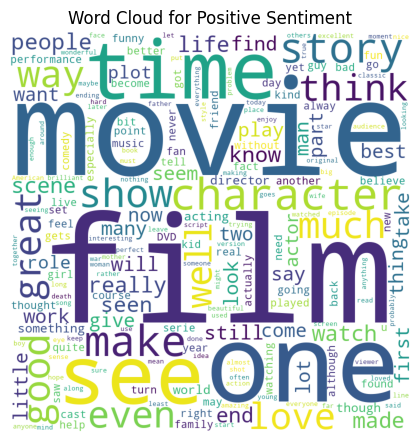

In [50]:
plt.figure(figsize = (4, 4), facecolor = None) 
plt.imshow(wordcloud_pos) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Word Cloud for Positive Sentiment")
plt.show()

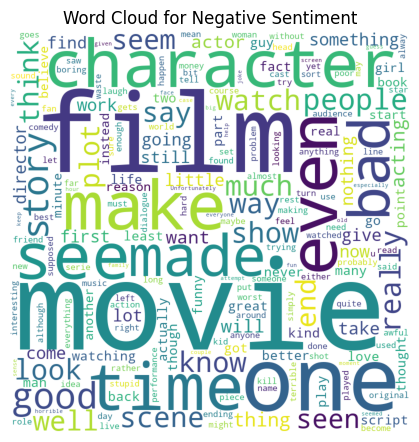

In [51]:
# Plotting the Negative Sentiment WordCloud
plt.figure(figsize = (4, 4), facecolor = None) 
plt.imshow(wordcloud_neg) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Word Cloud for Negative Sentiment")
plt.show()

Storing the dataframe in a parquet file. This will be used to train the model

In [30]:
import shutil
try:
    imdb_spark.write.parquet("../data-processed/imdb_data.parquet")
except:
    print('Directory already exists at path...\nDeleting the directory')
    shutil.rmtree('../data-processed/imdb_data.parquet')
    imdb_spark.write.parquet("../data-processed/imdb_data.parquet")

Directory already exists at path...
Deleting the directory
